In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import random
import torch
import os
import numpy as np
from torchvision.datasets import MNIST, SVHN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# from datasets import getPairedDataset
from model import EncoderA, EncoderB, DecoderA, DecoderB
from classifier import MNIST_Classifier, SVHN_Classifier
from util import unpack_data, apply_poe


from copy import deepcopy

import sys

sys.path.append("../")
import probtorch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Multiview Dateset
class ViewDataset(Dataset):
    def __init__(self, v1, v2):
        self.v1 = torch.tensor(v1).float()
        self.v2 = torch.tensor(v2).float()
        self.data_len = v1.shape[0]

    def __getitem__(self, index):
        return self.v1[index], self.v2[index], index

    def __len__(self):
        return self.data_len

In [4]:
data =  np.load(r"C:\Users\Harris_Lab\Projects\SPLICE\data\mnist\mnist_rotated_360.npz")

X = torch.Tensor(data["original"][:50000]).to(device).reshape(-1, 1, 28, 28)
Y = torch.Tensor(data["rotated"][:50000]).to(device).reshape(-1, 1, 28, 28)

X_val = (
    torch.Tensor(data["original"][50000:60000]).to(device).reshape(-1, 1, 28, 28)
)

Y_val = torch.Tensor(data["rotated"][50000:60000]).to(device).reshape(-1, 1, 28, 28)

X_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)
angles_test = data["angles"][60000:]
labels_test = data["labels"][60000:]

# dataset = ViewDataset(X[:50000], Y[:50000])
# val_dataset = ViewDataset(X_val, Y_val)

# train_loader = torch.utils.data.DataLoader(
#     dataset=dataset, batch_size=batch_size, shuffle=True
# )
# test_loader = torch.utils.data.DataLoader(
#     dataset=val_dataset, batch_size=batch_size, shuffle=False
# )

### True Private dimensionality

In [8]:
dims = [2,3,5,7,10]
n_shared = 30
n_privateA = 0
wseed = 0

top2_var = np.zeros(5)

for dim in dims:
    print("dim: ", dim)
    n_privateB = dim

    encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
    decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

    decA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decA.rar") % dim))
    encA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encA.rar") % dim))
    encB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encB.rar") % dim))
    decB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decB.rar") % dim))

    # encode
    q = encA(X_test, num_samples=1) 
    q = encB(Y_test, num_samples=1, q=q)    

    mu_poe, std_poe = apply_poe(
                    True,
                    q["sharedA"].dist.loc,
                    q["sharedA"].dist.scale,
                    q["sharedB"].dist.loc,
                    q["sharedB"].dist.scale,
                )
    q.normal(mu_poe, std_poe, name="poe")

    private = q["privateB"].dist.loc.squeeze(0).detach().cpu().numpy()

    pca = PCA(n_components=dim)
    pca.fit(private)

    # plt.figure()
    # plt.plot(np.arange(dim)+1, np.cumsum(pca.explained_variance_ratio_), marker='o')
    # plt.xlim(0, 10); plt.ylim(0, 1)

    # print(np.cumsum(pca.explained_variance_ratio_)[1])
    # print(dims.index(dim))

    top2_var[dims.index(dim)] = np.cumsum(pca.explained_variance_ratio_)[1]

dim:  2
dim:  3
dim:  5
dim:  7
dim:  10


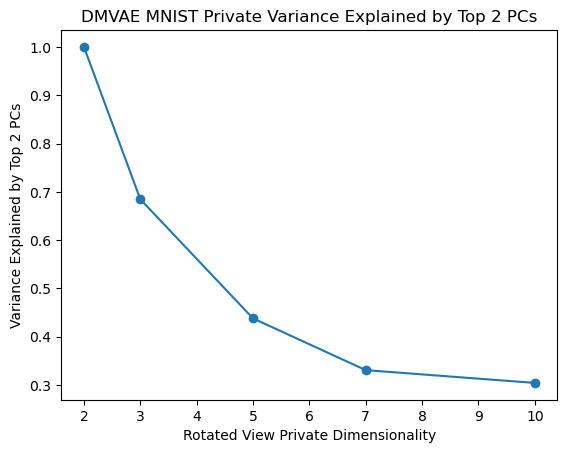

In [15]:
plt.plot(dims, top2_var, marker='o');
plt.title("DMVAE MNIST Private Variance Explained by Top 2 PCs")
plt.ylabel('Variance Explained by Top 2 PCs')
plt.xlabel('Rotated View Private Dimensionality')

plt.savefig("../../figures/jmlr/DMVAE_MNIST_extra_dims.svg", transparent=True, dpi=300)

<All keys matched successfully>

In [41]:
mu_poe, std_poe = apply_poe(
                    True,
                    q["sharedA"].dist.loc,
                    q["sharedA"].dist.scale,
                    q["sharedB"].dist.loc,
                    q["sharedB"].dist.scale,
                )
q.normal(mu_poe, std_poe, name="poe")

private = q["privateB"].dist.loc.squeeze(0).detach().cpu().numpy()

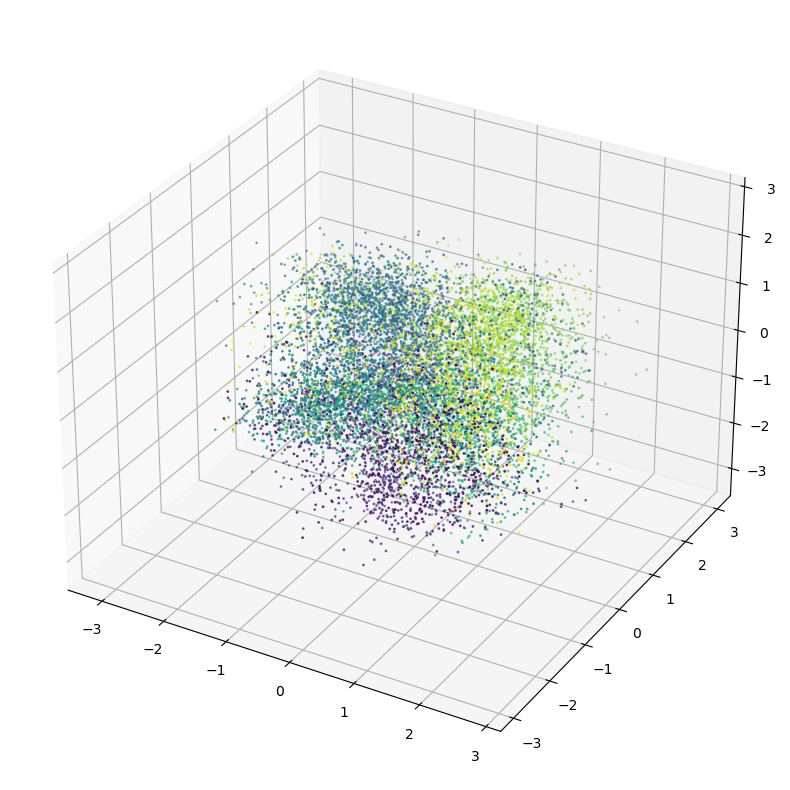

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(private[:, 0], private[:, 1], private[:, 2], c=angles_test, s = 1)

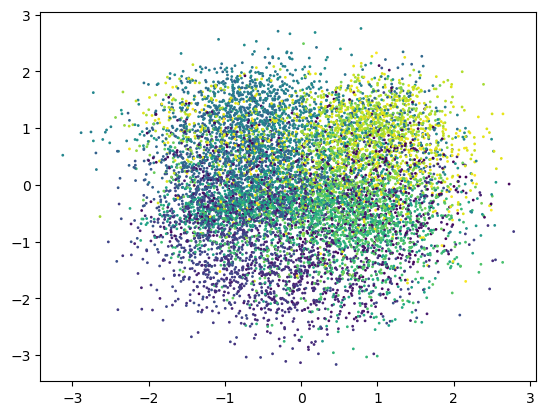

In [47]:
plt.scatter(private[:, 0], private[:, 2], c=angles_test, s=1)

In [ ]:
pA = decA(
    images1,
    {"sharedA": q["sharedA"], "sharedB": q["sharedB"], "poe": q["poe"]},
    q=q,
    num_samples=1,
)
pB = decB(
    images2,
    {"sharedB": q["sharedB"], "sharedA": q["sharedA"], "poe": q["poe"]},
    q=q,
    num_samples=1,
)